In [ ]:
# default_exp funcs.file_io

In [ ]:
%load_ext autoreload
%autoreload 2

# File handling

In [ ]:
#export
from decode_fish.imports import *
from decode_fish.funcs.utils import *
from tifffile import imread
from decode_fish.engine.microscope import Microscope
from decode_fish.engine.psf import crop_psf
from decode_fish.engine.psf import LinearInterpolatedPSF
from decode_fish.funcs.emitter_io import *

In [ ]:
#export
def tiff_imread(path):
    '''helper function to read tiff file with pathlib object or str'''
    if isinstance(path, str) : return imread(path)
    if isinstance(path, Path): return imread(str(path))

In [ ]:
#export
def load_model_state(model, path, file_name ='model.pkl'):
    model_dict = torch.load(Path(path)/file_name)
    model.load_state_dict(model_dict['state_dict'])
    model.unet.inp_scale = model_dict['scaling'][0]
    model.unet.inp_offset = model_dict['scaling'][1]
    return model

In [ ]:
#export
def simfish_to_df(sim_file, px_size=np.array([100.,100.,300.]), frame_idx=0):
    
    yxz = []
    with open(sim_file) as f:
        read = False
        for line in f:
            if 'Pos_Y' in line: 
                read = True
                continue
            if 'SPOTS_END' in line: break
            if read: yxz.append([float(s) for s in line.split()[:3]])

    yxz = np.array(yxz)/px_size
    loc_idx = np.arange(len(yxz))
    
    df = pd.DataFrame({'loc_idx': loc_idx,
                       'frame_idx': frame_idx,
                       'x': yxz[:,1]*px_size[0],
                       'y': yxz[:,0]*px_size[1], 
                       'z': yxz[:,2]*px_size[2], 
                       'prob': np.ones_like(loc_idx), 
                       'int': np.ones_like(loc_idx), 
                       'int_sig': np.ones_like(loc_idx), 
                       'x_sig': np.ones_like(loc_idx), 
                       'y_sig': np.ones_like(loc_idx), 
                       'z_sig': np.ones_like(loc_idx)})

    return df   

#export
def load_sim_fish(basedir, mrna_lvl=200, shape='cell3D', exp_strength='strong', cell_nr=0, shift=[-38,-38,-110]):
    
    spec_dir = f'/mRNAlevel_{mrna_lvl}/{shape}/{exp_strength}/'
    img_path = sorted(glob.glob(basedir + spec_dir + 'w1*.tif'))[cell_nr]
    cellname = Path(img_path).name.split('.')[0]
#     print(name)
    img = load_tiff_image(img_path)
    gt_df = simfish_to_df(img_path.split('.')[0] + '.txt')
    fq_nog_df = fq_gmm_df = DF()
    if os.path.exists(basedir + '/_results_detection/'):
        nog_path = Path(basedir + '/_results_detection/' + spec_dir + '/results_noGMM/' + cellname + '_res_NO_GMM.txt')
        gmm_path = Path(basedir + '/_results_detection/' + spec_dir + '/results_GMM/' + cellname + '_res_GMM.txt')

        if nog_path.is_file(): 
            fq_nog_df = simfish_to_df(nog_path)
            fq_nog_df = shift_df(fq_nog_df, shift)
        if gmm_path.is_file(): 
            fq_gmm_df = simfish_to_df(gmm_path)
            fq_gmm_df = shift_df(fq_gmm_df, shift)
        
    return img, gt_df, fq_nog_df, fq_gmm_df

#export
def big_fishq_to_df(file_str):
    
    csv = pd.read_csv(file_str,sep=';',names=['z','y','x'], index_col=False)

    zyx = np.array(csv)
    loc_idx = np.arange(len(zyx))

    df = pd.DataFrame({'loc_idx': loc_idx,
                       'frame_idx': np.zeros_like(loc_idx),
                       'x': zyx[:,2],
                       'y': zyx[:,1], 
                       'z': zyx[:,0], 
                       'prob': np.ones_like(loc_idx), 
                       'int': np.ones_like(loc_idx), 
                       'int_sig': np.ones_like(loc_idx), 
                       'x_sig': np.ones_like(loc_idx), 
                       'y_sig': np.ones_like(loc_idx), 
                       'z_sig': np.ones_like(loc_idx)})
    
    return df

def rsfish_to_df(file_str):
    
    csv = pd.read_csv(file_str,sep='  ',names=['x','y','z','?','??'], index_col=False)
    
    xyz = np.array(csv)
    loc_idx = np.arange(len(xyz))

    df = pd.DataFrame({'loc_idx': loc_idx,
                       'frame_idx': np.zeros_like(loc_idx),
                       'x': xyz[:,1],
                       'y': xyz[:,0], 
                       'z': xyz[:,2], 
                       'prob': np.ones_like(loc_idx), 
                       'int': np.ones_like(loc_idx), 
                       'int_sig': np.ones_like(loc_idx), 
                       'x_sig': np.ones_like(loc_idx), 
                       'y_sig': np.ones_like(loc_idx), 
                       'z_sig': np.ones_like(loc_idx)})
    
    return df

In [ ]:
#export
def load_tiff_image(image_path: str):
    "Given tiff stack path, loads the stack and converts it to a tensor. If necessary adds a dimension for the batch size"
    image_path = Path(image_path)
    image  = torch.tensor(tiff_imread(image_path).astype('float32'))
    if len(image.shape) == 3: image.unsqueeze_(0)
    assert len(image.shape) == 4, 'the shape of image must be 4, (1, Z, X, Y)'
    #removing minum values of the image
    return image

In [ ]:
# load_big_fishq('deepstorm/datasets/CodFish/smFISH_data_Titlow/detections/sgg_smFISH_4_spots.csv')
f_name = '../../../deepstorm/datasets/CodFish/smFISH_data_Titlow/detections/sgg_smFISH_4_spots.csv'
tiff = load_tiff_image(Path(f_name).parent.parent/'sgg_smFISH_4.tif')
print(tiff.shape)

df = big_fishq_to_df(f_name)

torch.Size([1, 25, 512, 512])


(0.0, 200.0)

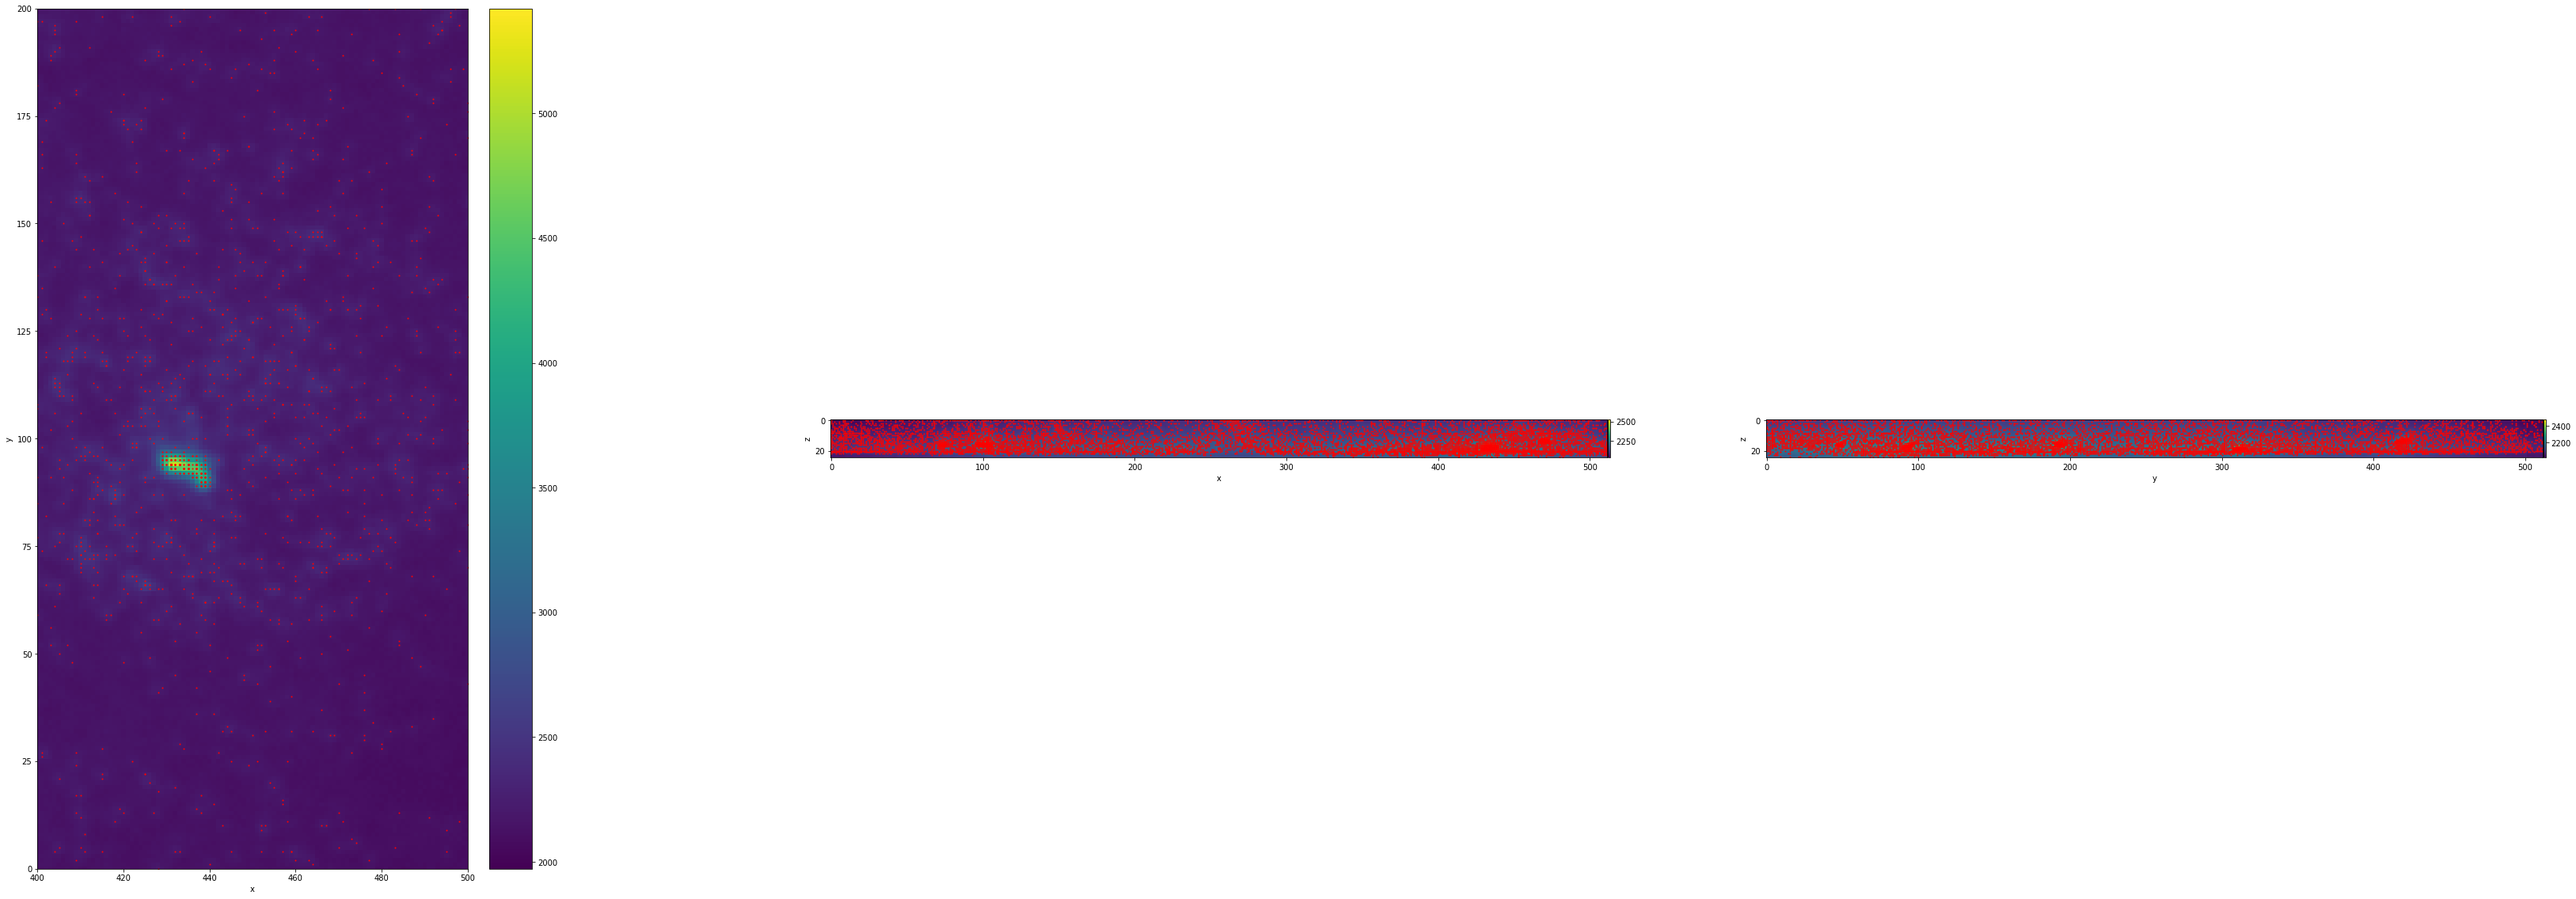

In [ ]:
from decode_fish.funcs.plotting import *
from decode_fish.funcs.emitter_io import *

axes = plot_3d_projections(tiff[0], size=20)
axes[0].scatter(df['x'],df['y'], color='red', s=1)
axes[1].scatter(df['x'],df['z'], color='red', s=1)
axes[2].scatter(df['y'],df['z'], color='red', s=1)
axes[0].set_xlim(400,500)
axes[0].set_ylim(0,200)

In [ ]:
#export
def get_gaussian_psf(size_zyx, radii):
    PSF = LinearInterpolatedPSF(size_zyx, device='cuda')
    state_dict = PSF.state_dict()
    gauss_vol = gaussian_sphere(size_zyx, radii, [size_zyx[0]//2,size_zyx[1]//2,size_zyx[2]//2])
    gauss_vol = gauss_vol/gauss_vol.sum()
    state_dict['psf_volume'][0] = torch.cuda.FloatTensor(gauss_vol)
    PSF.load_state_dict(state_dict)
    
    return PSF

def load_psf_noise_micro(cfg):
    
    if cfg.data_path.psf_path:
        psf_state = torch.load(cfg.data_path.psf_path)
        psf = LinearInterpolatedPSF(psf_state['psf_volume'].shape[-3:], cfg.PSF.device)
        psf.load_state_dict(psf_state)
        
        if cfg.PSF.psf_extent_zyx:
            psf = crop_psf(psf,cfg.PSF.psf_extent_zyx)
            
    else:
        
        psf = get_gaussian_psf(cfg.PSF.psf_extent_zyx, cfg.PSF.gauss_radii)

    noise = hydra.utils.instantiate(cfg.noise)
    micro = Microscope(parametric_psf=[psf], noise=noise, multipl=cfg.microscope.multipl, psf_noise=cfg.microscope.psf_noise, clamp_mode=cfg.microscope.clamp_mode).cuda()
    
    return psf, noise, micro

def load_post_proc(cfg):
    if cfg.other.pp == 'si':
        return hydra.utils.instantiate(cfg.post_proc_si)
    if cfg.other.pp == 'isi':
        return hydra.utils.instantiate(cfg.post_proc_isi)

In [ ]:
cfg = OmegaConf.load(default_conf)
psf, noise, micro = load_psf_noise_micro(cfg)

NameError: name 'OmegaConf' is not defined

In [ ]:
cfg = OmegaConf.load(f'../config/experiment/msp300_smFISH_3_2.yaml')
psf, noise, micro = load_psf_noise_micro(cfg)

In [ ]:
cfg.microscope

{'multipl': 90, 'psf_extent_zyx': [21, 21, 21], 'psf_noise': 0.0005, 'clamp_mode': 'cx'}

array([<AxesSubplot:xlabel='x', ylabel='y'>,
       <AxesSubplot:xlabel='x', ylabel='z'>,
       <AxesSubplot:xlabel='y', ylabel='z'>], dtype=object)

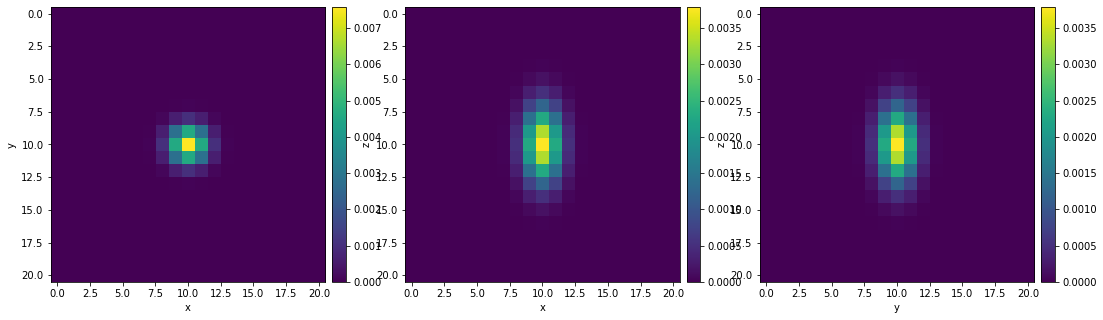

In [ ]:
from decode_fish.funcs.plotting import *
plot_3d_projections(psf.psf_volume[0])

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted index.ipynb.
